In [1]:
# Settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.metrics as metrics
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import NearMiss
from scipy.stats import norm

tf.set_random_seed(1)
np.random.seed(1)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
# Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Data
df = pd.read_csv('creditcard.csv')
df = df.sample(frac=1).reset_index(drop=True)

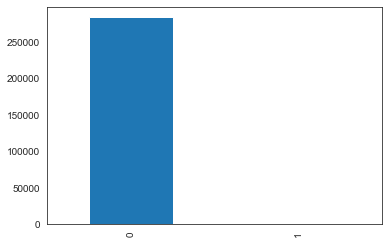

0    284315
1       492
Name: Class, dtype: int64
0    0.998273
1    0.001727
Name: Class, dtype: float64


In [4]:
## EDA
# unbalance b/w responses
with sns.axes_style("white"):
    df.Class.value_counts().plot(kind='bar')
    plt.show()
print(df['Class'].value_counts())
print(df['Class'].value_counts()/len(df['Class']))

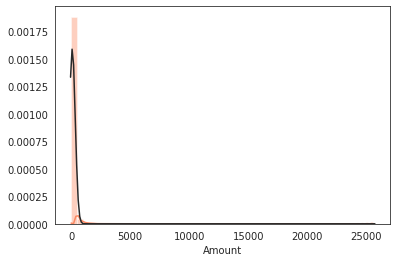

25691.16 0.0


In [5]:
# amounts - needed to be normalized!
with sns.axes_style("white"):
    sns.distplot(df.Amount, fit=norm, color='#FB8861')
plt.show()
print(np.max(df.Amount.values), np.min(df.Amount.values))

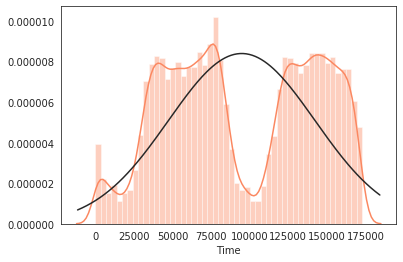

In [6]:
# time
with sns.axes_style("white"):
    sns.distplot(df.Time, fit=norm, color='#FB8861')
plt.show() #drop out
# It seems like mixture of 2 ot more continuous distributions.

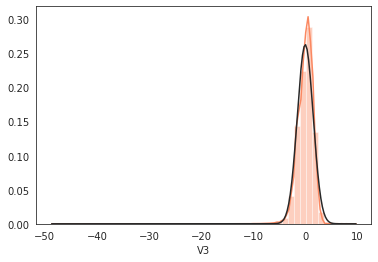

In [7]:
# others
with sns.axes_style("white"):
    sns.distplot(df.V3, fit=norm, color='#FB8861')
plt.show()

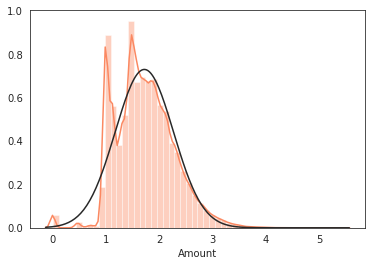

In [8]:
# Normalize & Standardize
df.Amount = df.Amount**(1/6)

with sns.axes_style("white"):
    sns.distplot(df.Amount, fit=norm, color='#FB8861')
plt.show()

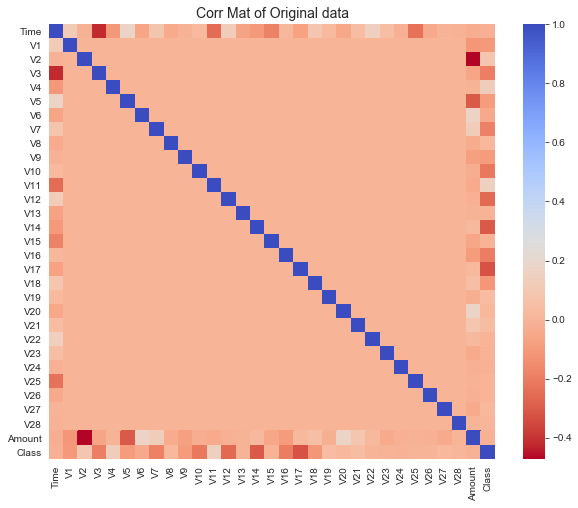

In [9]:
# Heatmap for the originial
with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    sub_sample_corr_2 = df.corr()
    sns.heatmap(sub_sample_corr_2, cmap='coolwarm_r')
    plt.title('Corr Mat of Original data', fontsize=14)
    plt.show()

In [10]:
# Split the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

x = df.drop(['Class','Time'], axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

x_train = tf.keras.utils.normalize(x_train.values, axis = 1, order = 1) 
x_test = tf.keras.utils.normalize(x_test.values, axis = 1, order = 1) 
y_train = y_train.values
y_test = y_test.values

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
np.sum(y_train)

(227846, 29) (227846, 1) (56961, 29) (56961, 1)


394

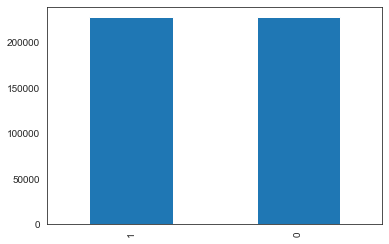

1    227452
0    227452
Name: Class, dtype: int64
1    0.5
0    0.5
Name: Class, dtype: float64


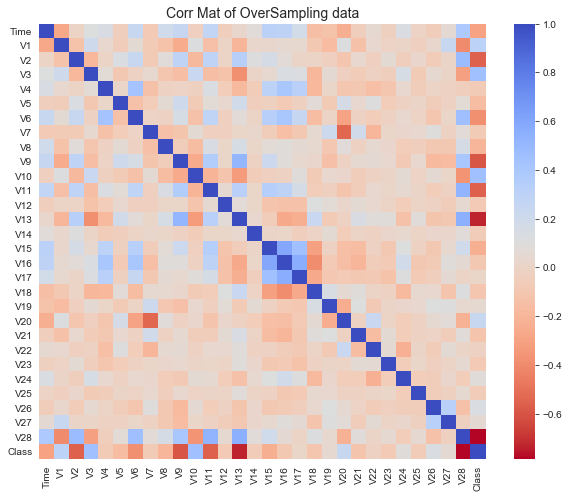

In [11]:
## OverSampling
ss = SVMSMOTE(sampling_strategy='minority')
x_train_o, y_train_o = ss.fit_sample(x_train, y_train)
col = df.columns
df1 = pd.DataFrame(x_train_o.reshape(454904,29), columns=col[:29])
df2 = pd.DataFrame(y_train_o.reshape(454904,1), columns=col[30:])
df_o = pd.concat([df1,df2], axis=1)
with sns.axes_style("white"):
    df_o.Class.value_counts().plot(kind='bar')
    plt.show()
print(df_o['Class'].value_counts())
print(df_o['Class'].value_counts()/len(df_o['Class']))

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    sub_sample_corr_2 = df_o.corr()
    sns.heatmap(sub_sample_corr_2, cmap='coolwarm_r')
    plt.title('Corr Mat of OverSampling data', fontsize=14)
    plt.show()
    
y_train_o = y_train_o.reshape(-1,1)

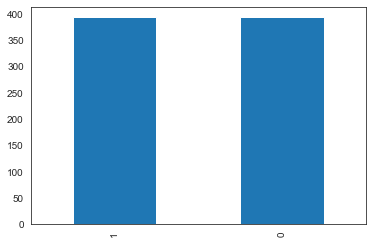

1    394
0    394
Name: Class, dtype: int64
1    0.5
0    0.5
Name: Class, dtype: float64


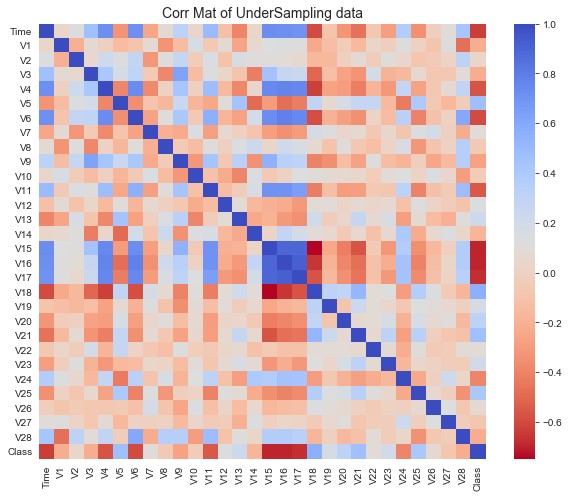

In [12]:
## UnderSampling
nm = NearMiss(sampling_strategy='majority')
x_train_u, y_train_u = nm.fit_sample(x_train, y_train)

df1 = pd.DataFrame(x_train_u.reshape(788,29), columns=col[:29])
df2 = pd.DataFrame(y_train_u.reshape(788,1), columns=col[30:])
df_u = pd.concat([df1,df2], axis=1)
with sns.axes_style("white"):
    df_u.Class.value_counts().plot(kind='bar')
    plt.show()
print(df_u['Class'].value_counts())
print(df_u['Class'].value_counts()/len(df_u['Class']))
with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    sub_sample_corr_2 = df_u.corr()
    sns.heatmap(sub_sample_corr_2, cmap='coolwarm_r')
    plt.title('Corr Mat of UnderSampling data', fontsize=14)
    plt.show()
    
y_train_u = y_train_u.reshape(-1,1)

In [13]:
# Learning Parameters
epochs = 4000
batch_size = 512
lr = 1e-3

In [14]:
# Neural Net Model
x = tf.placeholder(tf.float32, (None,29)) 
y = tf.placeholder(tf.float32, (None,1)) 

init_b = tf.keras.initializers.constant(0.0)
init_w = tf.keras.initializers.VarianceScaling(mode='fan_in')

b1 = tf.get_variable('b1', (29,), tf.float32, init_b)
w1 = tf.get_variable('w1', (29,29), tf.float32, init_w)

b2 = tf.get_variable('b2', (15,), tf.float32, init_b)
w2 = tf.get_variable('w2', (29,15), tf.float32, init_w)

b3 = tf.get_variable('b3', (1,), tf.float32, init_b)
w3 = tf.get_variable('w3', (15,1), tf.float32, init_w)

x1 = tf.nn.leaky_relu(x @ w1 + b1) 
bn1 = tf.layers.batch_normalization(x1, 1, momentum=0.9)
x2 = tf.nn.leaky_relu(bn1 @ w2 + b2) 
bn2 = tf.layers.batch_normalization(x2, 1, momentum=0.9)
logits = bn2 @ w3 + b3 #none,1

entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy)  

train = tf.train.AdamOptimizer(lr).minimize(loss) 

predicted = tf.nn.sigmoid(logits)
correct = tf.equal(tf.round(predicted),y)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
def shuffle_batch(x, y, batch_size): #data를 batch size에 맞게 자르는 것,
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx]

In [16]:
# NN for the original
with tf.Session() as sess:
    init.run()
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)
        if (i+1) % 500 == 0:
            print()
            print('epoch {}/{}'.format(i+1, epochs), end=' ')

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, tf.cast(tf.round(predicted),tf.int32)], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 500/4000 
epoch 1000/4000 
epoch 1500/4000 
epoch 2000/4000 
epoch 2500/4000 
epoch 3000/4000 
epoch 3500/4000 
epoch 4000/4000 

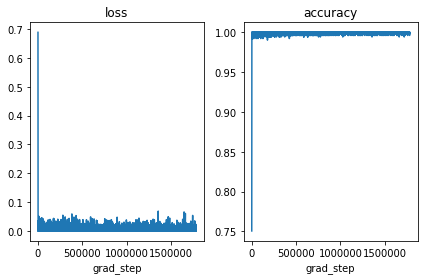

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

0.2755102040816326
0.00035172256124369096
[[56843    20]
 [   27    71]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.78      0.72      0.75        98

    accuracy                           1.00     56961
   macro avg       0.89      0.86      0.88     56961
weighted avg       1.00      1.00      1.00     56961

0.9991748740366215
0.7802197802197802
0.7244897959183674
0.7513227513227514
0.8620690366785618


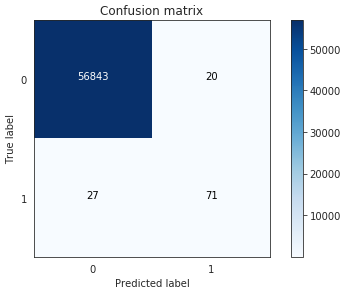

In [18]:
# Results of NN for the original data set
print(confusion_matrix(y_test, y_test_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_test_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))
print(roc_auc_score(y_test, y_test_pred))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))
plt.show()

In [19]:
# NN for the undersampling
with tf.Session() as sess:
    init.run()
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        for x_batch, y_batch in shuffle_batch(x_train_u, y_train_u, batch_size):
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)
        if (i+1) % 500 == 0:
            print()
            print('epoch {}/{}'.format(i+1, epochs), end=' ')

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, tf.cast(tf.round(predicted),tf.int32)], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 500/4000 
epoch 1000/4000 
epoch 1500/4000 
epoch 2000/4000 
epoch 2500/4000 
epoch 3000/4000 
epoch 3500/4000 
epoch 4000/4000 

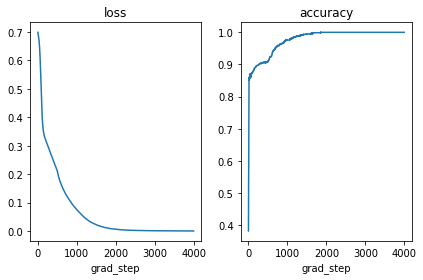

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

0.11224489795918367
0.7501714647486063
[[14206 42657]
 [   11    87]]
              precision    recall  f1-score   support

           0       1.00      0.25      0.40     56863
           1       0.00      0.89      0.00        98

    accuracy                           0.25     56961
   macro avg       0.50      0.57      0.20     56961
weighted avg       1.00      0.25      0.40     56961

0.2509260722248556
0.0020353733857383493
0.8877551020408163
0.004061435040380935
0.568791818646105


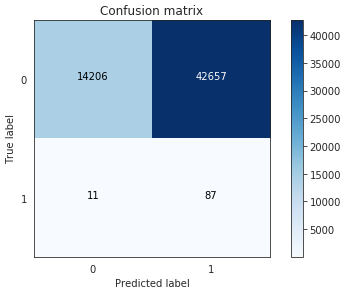

In [21]:
# Results of NN for the original data set
print(confusion_matrix(y_test, y_test_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_test_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))
print(roc_auc_score(y_test, y_test_pred))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))
plt.show()

In [22]:
# NN for the oversampling
with tf.Session() as sess:
    init.run()
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        for x_batch, y_batch in shuffle_batch(x_train_o, y_train_o, batch_size):
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)
        if (i+1) % 500 == 0:
            print()
            print('epoch {}/{}'.format(i+1, epochs), end=' ')

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, tf.cast(tf.round(predicted),tf.int32)], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 500/4000 
epoch 1000/4000 
epoch 1500/4000 
epoch 2000/4000 
epoch 2500/4000 
epoch 3000/4000 
epoch 3500/4000 
epoch 4000/4000 

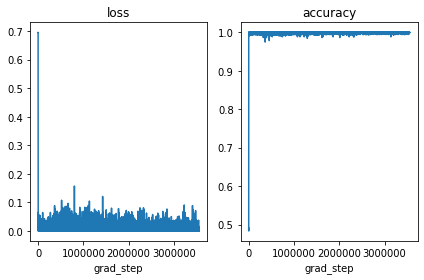

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

0.24489795918367346
0.0004572393296167983
[[56837    26]
 [   24    74]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.74      0.76      0.75        98

    accuracy                           1.00     56961
   macro avg       0.87      0.88      0.87     56961
weighted avg       1.00      1.00      1.00     56961

0.9991222064219378
0.74
0.7551020408163265
0.7474747474747474
0.8773224007433549


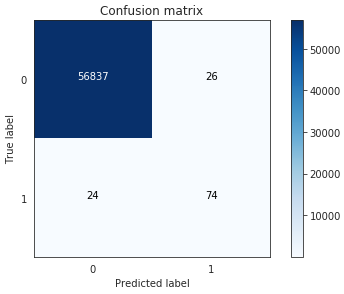

In [24]:
# Results of NN for the original data set
print(confusion_matrix(y_test, y_test_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_test_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))
print(roc_auc_score(y_test, y_test_pred))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))
plt.show()